In [1]:
import pandas as pd
import tensorflow as tf
import torch

In [2]:
# load the dataset
df = pd.read_parquet('healthCare.parquet')
# select the first 500 rows of the dataset
df = df.iloc[:500, :]
# select two columns
df = df[['input', 'output']]   # original text and summary
data = df.copy()
data.head()

,input,output
0,I woke up this morning feeling the whole room ...,"Hi, Thank you for posting your query. The most..."
1,My baby has been pooing 5-6 times a day for a ...,Hi... Thank you for consulting in Chat Doctor....
2,"Hello, My husband is taking Oxycodone due to a...","Hello, and I hope I can help you today.First, ..."
3,lump under left nipple and stomach pain (male)...,HI. You have two different problems. The lump ...
4,I have a 5 month old baby who is very congeste...,Thank you for using Chat Doctor. I would sugge...


In [3]:
from myTokenizer import myTokenizer
ThisTokenizer = myTokenizer(num_words=15000)
# ThisTokenizer.train_from_parquet(parquet_path='healthCare.parquet', inputCol='input', outputCol='output')
# ThisTokenizer.save_tokenizer('/tokenizer/tokenizerForHealthCare.pkl')

TOKENIZER = ThisTokenizer.load_tokenizer('/tokenizer/tokenizerForHealthCare.pkl')
print("tokenizer done, with length", len(TOKENIZER.word_index) + 1)
print("vocab size:", TOKENIZER.num_words)

✅ Tokenizer is loaded successfully: /tokenizer/tokenizerForHealthCare.pkl
tokenizer done, with length 41978
vocab size: 15000


In [4]:
word2idx = TOKENIZER.word_index

# show the length of the vocabulary
print(f"Vocabulary size: {len(word2idx)}")
print(f"Number of words: {TOKENIZER.num_words + 1}")

idx2word = {v: k for k, v in word2idx.items()}

for word, idx in word2idx.items():
    print(f"{word}: {idx}")
    if idx > 30:
        break

UNK_ID = word2idx['<UNKNOWN>']
print(f"UNK_ID: {UNK_ID}")
print(f". token: {word2idx['.']}")

Vocabulary size: 41977
Number of words: 15001
<UNKNOWN>: 1
.: 2
,: 3
i: 4
and: 5
the: 6
to: 7
a: 8
is: 9
of: 10
you: 11
in: 12
for: 13
it: 14
your: 15
my: 16
have: 17
<start>: 18
<end>: 19
be: 20
this: 21
with: 22
can: 23
doctor: 24
not: 25
that: 26
on: 27
if: 28
or: 29
are: 30
as: 31
UNK_ID: 1
. token: 2


In [5]:
TRAINING_SIZE = 3550
BATCH_SIZE = 64
INPUT_LIMIT = 200
OUTPUT_LIMIT = 250
VOCAB_SIZE = TOKENIZER.num_words + 1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-4

df = pd.read_parquet('healthCare.parquet').dropna()
# input_texts = df['input'].apply(ThisTokenizer.clean_text).tolist()
# target_texts = df['output'].apply(ThisTokenizer.clean_text).tolist()

In [6]:
def build_clean_dataset(df, tokenizer, max_input_len=200, max_target_len=250, max_samples=TRAINING_SIZE, unk_id=1):
    clean_inputs = []
    clean_targets = []

    for i in range(len(df)):
        raw_input = df.iloc[i]['input']
        raw_output = df.iloc[i]['output']

        # 预处理文本（加 <start>/<end>）
        input_text = myTokenizer.clean_text(str(raw_input))
        target_text = myTokenizer.clean_text(str(raw_output))

        input_ids = tokenizer.texts_to_sequences([input_text])[0]
        target_ids = tokenizer.texts_to_sequences([target_text])[0]

        # 条件 1：UNK 占比限制
        if input_ids.count(unk_id) / len(input_ids) > 0.3:
            continue
        if target_ids.count(unk_id) / len(target_ids) > 0.3:
            continue

        # 条件 2：是否在截断前包含 <end> token
        end_id = tokenizer.word_index.get("<end>")
        if end_id is None or end_id not in input_ids[:max_input_len]:
            continue
        if end_id not in target_ids[:max_target_len]:
            continue

        # 截断 + pad 可交由 ChatDataset 完成
        clean_inputs.append(input_text)
        clean_targets.append(target_text)

        if len(clean_inputs) >= max_samples:
            break

    print(f"✅ SUCCESSFULLY GET CLEAN DATA: {len(clean_inputs)}")
    return clean_inputs, clean_targets


input_texts, target_texts = build_clean_dataset(
    df, tokenizer=TOKENIZER,
    max_input_len=INPUT_LIMIT, max_target_len=OUTPUT_LIMIT, max_samples=TRAINING_SIZE,unk_id=UNK_ID
)


✅ SUCCESSFULLY GET CLEAN DATA: 3550


In [7]:
# print the first line of the input and target texts
print("input text:", input_texts[0])
print("target text:", target_texts[0])

input text: <start> i woke up this morning feeling the whole room is spinning when i was sitting down . i went to the bathroom walking unsteadily , as i tried to focus i feel nauseous . i try to vomit but it wont come out . . after taking panadol and sleep for few hours , i still feel the same . . by the way , if i lay down or sit down , my head do not spin , only when i want to move around then i feel the whole world is spinning . . and it is normal stomach discomfort at the same time ? earlier after i relieved myself , the spinning lessen so i am not sure whether its connected or coincidences . . thank you doc ! <end>
target text: <start> hi , thank you for posting your query . the most likely cause for your symptoms is benign paroxysmal positional vertigo (bppv) , a type of peripheral vertigo . in this condition , the most common symptom is dizziness or giddiness , which is made worse with movements . accompanying nausea and vomiting are common . the condition is due to problem in t

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from utils.dataCollect import ChatDataset

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    input_texts, target_texts, test_size=0.1, random_state=42)

train_set = ChatDataset(train_inputs, train_targets, TOKENIZER, max_len=200, max_target_len=200)
val_set = ChatDataset(val_inputs, val_targets, TOKENIZER, max_len=200, max_target_len=200)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)


In [9]:
from models.miniTransformerV2 import TransformerChat

model = TransformerChat(vocab_size=VOCAB_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)


In [ ]:
import matplotlib.pyplot as plt

from tqdm import tqdm
EPOCHS = 2000

train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    # ======== Train ========
    model.train()
    total_loss = 0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
    for src, tgt in train_loop:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        tgt_mask = torch.triu(torch.ones(tgt_input.size(1), tgt_input.size(1)) * float('-inf'), diagonal=1).to(DEVICE)

        out = model(src, tgt_input, tgt_mask=tgt_mask)
        loss = loss_fn(out.reshape(-1, VOCAB_SIZE), tgt_output.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    avg_train_loss = total_loss / len(train_loader)

    # ======== Validation ========
    model.eval()
    total_val_loss = 0
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch} [Val]")
    with torch.no_grad():
        for src, tgt in val_loop:
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            tgt_mask = torch.triu(torch.ones(tgt_input.size(1), tgt_input.size(1)) * float('-inf'), diagonal=1).to(DEVICE)

            logits = model(src, tgt_input, tgt_mask=tgt_mask)
            loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))

            total_val_loss += loss.item()
            val_loop.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_train_loss <= 0.05 or avg_val_loss <= 0.05:
        print(f"✅ Training stopped early at epoch {epoch} as loss reached {avg_train_loss:.4f}")
        break


    
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig('checkpoint/loss_curve_transformerV2_'+str(TRAINING_SIZE)+'.png')
plt.show()



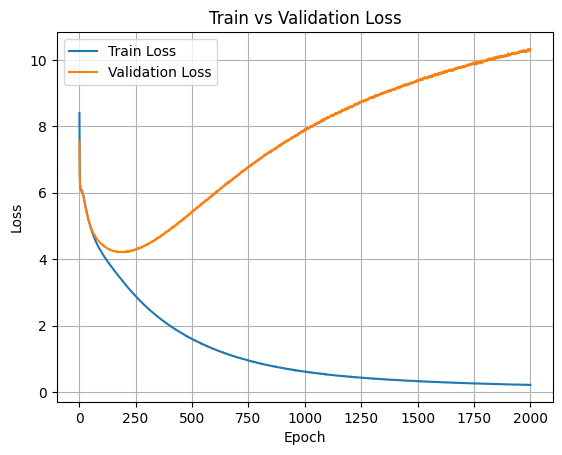

In [11]:
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig('checkpoint/loss_curve_transformerV2_'+str(TRAINING_SIZE)+'.png')
plt.show()

In [12]:
import os

# Save the model
os.makedirs("checkpoint", exist_ok=True)
torch.save(model.state_dict(), 'checkpoint/weight_transformerV2_'+str(TRAINING_SIZE)+'.pth')
print('Model saved as weight_transformerV2_'+str(TRAINING_SIZE)+'.pth')

print(f"Epoch {epoch} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Model saved as weight_transformerV2_3550.pth
Epoch 2000 - Train Loss: 0.2163 | Val Loss: 10.3122


In [13]:
# ✅ 绘图
